In [116]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import copy
import warnings

import h5py

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

from astropy.stats import SigmaClip
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel

from photutils.isophote import Ellipse
from photutils.isophote import EllipseGeometry
from photutils.isophote import build_ellipse_model
from photutils.isophote import EllipseSample, Isophote, IsophoteList
from photutils.isophote.sample import CentralEllipseSample
from photutils.isophote.fitter import CentralEllipseFitter 

from photutils.segmentation import detect_sources
from photutils.segmentation import detect_threshold
from photutils.segmentation import deblend_sources
from photutils.background import Background2D
from photutils.background import SExtractorBackground

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Check the versions of the software
import astropy 
import photutils

print(astropy.__version__)
print(photutils.__version__)

5.0
1.3.0


### Get the stellar mass map

In [3]:
file = '/Users/song/Downloads/galaxies_stellarmaps_lr_all_ptl_tng100_072.hdf5'

with h5py.File(file,'r') as f:
    map_data = np.array(f['map_star_rho_xy'][0]) #2d density map of a single galaxy

### Data Preparation

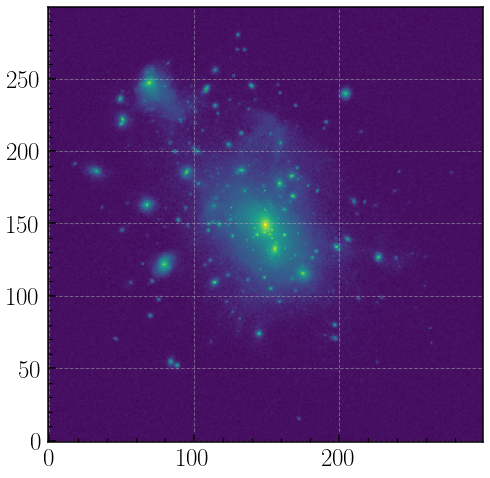

In [4]:
# Shape of the image
x_size, y_size = map_data.shape

# Get the (min, max) values of the map
map_max = map_data.max()
map_min = map_data[map_data > 0.0].min()   # none-zero min

# Normalize the data so the minimum non-zero value is `min_value`
min_value = 0.01
norm_factor = map_min / min_value
map_norm = map_data / norm_factor

# It is also usually a good idea to add noises to the image 
rng = np.random.default_rng(860722)
sig_noise = 0.1
map_noise = map_norm + rng.normal(loc=0.0, scale=sig_noise, size=map_data.shape)

plt.figure(figsize=(8, 8))
plt.imshow(np.arcsinh(map_norm), origin='lower')
plt.imshow(np.arcsinh(map_noise), origin='lower')

### Initial 1-D model

# Trying initial position at 4 pixel...


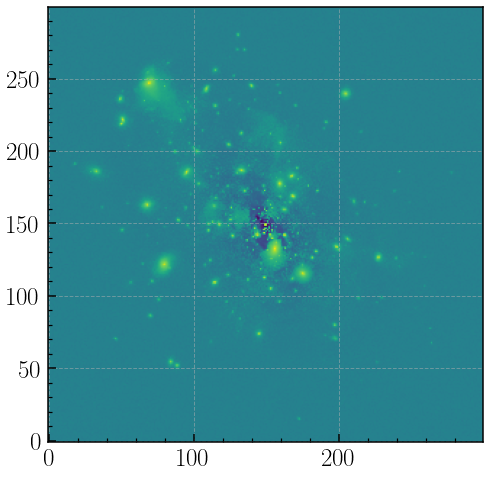

In [40]:
# Key parameters here are:
# sma0: initial radius to fit
# maxsma: maximum radius to fit
# step: step size of the fitting
#     - 0.1 is about right, you don't want to make it too small.
# sclip: sigma-threshold for sigma-clipping
#     - Lower threshold will make the 1-D profile more resistence to contamination
# nclip: number of times of sigma-clipping
# integrmode: method to calculate the 1-D profile 
#     - median makes it more resistence to contamination as well

sma0_ini = 4
maxsma = x_size / 2 * 1.2
step_ini = 0.1
sclip_ini = 2.0
nclip_ini = 3
integrmode = 'median'

# Initial guesses of the geometry
# We will assume the galaxy center is at the center of the image first

# Photutils.isophote will bail out if the starting position is bad (contaminations, off-center...could be caused by several things)
# So we want to try a series of starting positions to make sure it can run through 
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    factor = np.arange(1.0, 6, 0.5)
    for ii, fac in enumerate(factor): # try a few different starting sma0
        sma0 = sma0_ini * fac
        try:
            print("# Trying initial position at {:d} pixel...".format(int(sma0)))
            geo_ini = EllipseGeometry(
                x0=x_size / 2, y0=y_size / 2, sma=sma0, eps=0.0, pa=0. * np.pi / 180.)

            ell_ini = Ellipse(map_noise, geo_ini)

            iso_ini = ell_ini.fit_image(
                sma0=sma0, minsma=0.0, maxsma=maxsma, step=step_ini, conver=0.05, minit=10, maxit=200, 
                fflag=0.7, maxgerr=0.5, sclip=sclip_ini, nclip=nclip_ini, 
                integrmode=integrmode, linear=None, maxrit=None, 
                fix_center=False, fix_pa=False, fix_eps=False)
        except:
            iso_ini = []
            sma0 = sma0_ini
        if len(iso_ini) > 0:
            break
            
# Stop code 3, 4, 5 means the fitting of the isophote is not very reliable
mask_valid = iso_ini.stop_code < 3

if (~np.isfinite(iso_geo.intens)).sum() == 0:
    # Build a 2-D model based on the 1-D 
    mod_ini = build_ellipse_model(map_data.shape, iso_ini, high_harmonics=True)

    # Get the residual of the model 
    res_ini = map_noise - mod_ini

    # Display the residual of the model
    plt.figure(figsize=(8, 8))
    plt.imshow(np.arcsinh(map_noise - mod_ini), origin='lower')
else: 
    print("# Something wrong with the fitting!")
    # Normally this happens at the edge of the image, when the maximum radius is too large to obtain a useful fit.
    # Shrink the maxsma could solve the issue

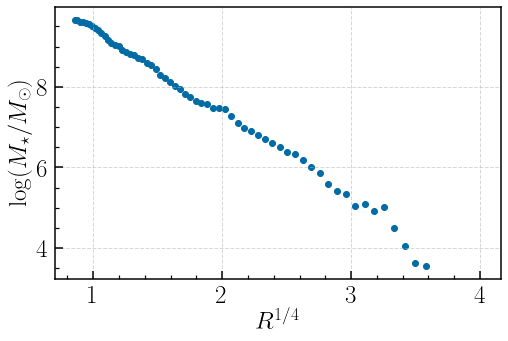

In [41]:
# Plot the mass or mass density profile depending on the unit of the map

plt.figure(figsize=(8, 5))
plt.xlim(0.7, (x_size / 2 * 2) ** 0.25)

# We typically use R^(1.4) to scale the radius.
# You can use log10 as well.
plt.scatter(iso_ini.sma ** 0.25, np.log10(iso_ini.intens * norm_factor))
_ = plt.xlabel(r'$R^{1/4}$', fontsize=25)
_ = plt.ylabel(r'$\log (M_{\star}/M_{\odot})$', fontsize=25)

# There are some "wiggle and bumps" on the profile due to 1) contaminations from other objects; 2) isophotes with quickly varying shapes.

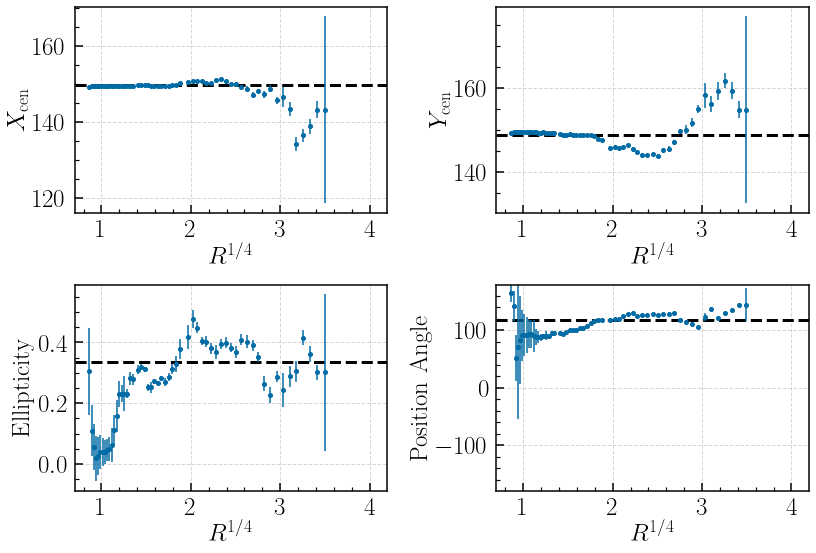

In [42]:
# We can see that the center varies a bit and the shape of the isophote changes too. 

# Initial estimates of ellipticity and position angles
# Note that the galaxy center based on the light profile could have <1 pixel offset from the image center. 
# If you want to fix the galaxy center, it is actually better to use these values. 
x0_ini = np.mean(iso_ini.x0[mask_valid & (iso_ini.sma >= 0.1) & (iso_ini.sma <= 20)])
y0_ini = np.mean(iso_ini.y0[mask_valid & (iso_ini.sma >= 0.1) & (iso_ini.sma <= 20)])

# Here are the average ellipticity and position angles.
# If it is not that important, you can directly adopt these values for extracting 1-D profiles. 
# You can also define the mean shape differently, e.g., use a different radial range or use mass-weighted mean
eps_ini = np.mean(iso_ini.eps[mask_valid & (iso_ini.sma >= 3)])
pa_ini = np.mean(iso_ini.pa[mask_valid & (iso_ini.sma >= 3)])

plt.figure(figsize=(12, 8))
plt.figure(1)

plt.subplot(221)
plt.xlim(0.7, np.max(iso_ini.sma[mask_valid]) ** 0.25 * 1.2)
plt.axhline(x0_ini, linewidth=3, linestyle='--', c='k')
plt.errorbar(iso_ini.sma[mask_valid] ** 0.25, iso_ini.x0[mask_valid], 
             yerr=iso_ini.x0_err[mask_valid], fmt='o', markersize=4)
_ = plt.xlabel(r'$R^{1/4}$', fontsize=25)
_ = plt.ylabel(r'$X_{\rm cen}$', fontsize=25)

plt.subplot(222)
plt.xlim(0.7, np.max(iso_ini.sma[mask_valid]) ** 0.25 * 1.2)
plt.axhline(y0_ini, linewidth=3, linestyle='--', c='k')
plt.errorbar(iso_ini.sma[mask_valid] ** 0.25, iso_ini.y0[mask_valid], 
             yerr=iso_ini.y0_err[mask_valid], fmt='o', markersize=4)
_ = plt.xlabel(r'$R^{1/4}$', fontsize=25)
_ = plt.ylabel(r'$Y_{\rm cen}$', fontsize=25)

plt.subplot(223)
plt.xlim(0.7, np.max(iso_ini.sma[mask_valid]) ** 0.25 * 1.2)
plt.axhline(eps_ini, linewidth=3, linestyle='--', c='k')
plt.errorbar(iso_ini.sma[mask_valid] ** 0.25, iso_ini.eps[mask_valid], 
             yerr=iso_ini.ellip_err[mask_valid], fmt='o', markersize=4)
_ = plt.xlabel(r'$R^{1/4}$', fontsize=25)
_ = plt.ylabel(r'$\rm Ellipticity$', fontsize=25)

plt.subplot(224)
plt.xlim(0.7, np.max(iso_ini.sma[mask_valid]) ** 0.25 * 1.2)
plt.ylim(-179, 179)
plt.axhline(pa_ini * 180.0 / np.pi, linewidth=3, linestyle='--', c='k')
plt.errorbar(iso_ini.sma[mask_valid] ** 0.25, iso_ini.pa[mask_valid] * 180.0 / np.pi, 
             yerr=(iso_ini.pa_err[mask_valid] * 180.0 / np.pi), fmt='o', markersize=4)
_ = plt.xlabel(r'$R^{1/4}$', fontsize=25, c='k')
_ = plt.ylabel(r'$\rm Position\ Angle$', fontsize=25)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

### Detect, deblend, and mask contaminating sources on the residual

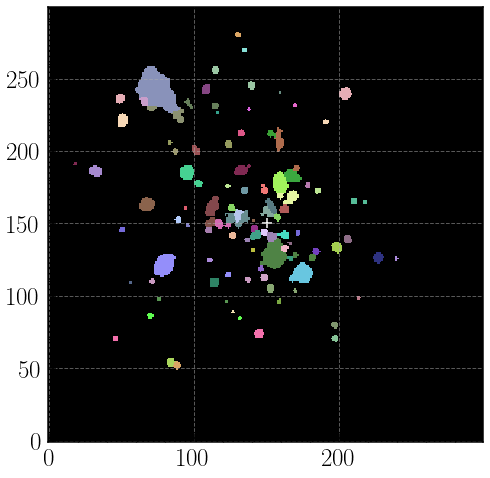

In [43]:
# Detection threshold and convolution kernel
# key parameters here are
det_thre = 15

# We only want to detect the highly significant sources
# Here the image "noise" or RMS is not well defined, so need to experiment to get the best results.
res_threshold = detect_threshold(res_ini, nsigma=det_thre)

# The convolution kernel also helps us to ignore tiny "dots"
res_kernel = Gaussian2DKernel(2.0 * gaussian_fwhm_to_sigma, x_size=5, y_size=5)
res_kernel.normalize()

# Segmentations from initial detections
res_segm = detect_sources(res_ini, res_threshold, npixels=4, kernel=res_kernel)

# Deblend the sources
res_debl = deblend_sources(
    res_ini, res_segm, npixels=4, kernel=res_kernel, nlevels=32, contrast=0.0001)

# We need to remove the segment at the center of the image 
# Define a small area around the center, and remove the segments there
cen_rad = 3
cen_low = int(x_size / 2 - 3)
cen_upp = int(x_size / 2 + 3)

idx_uniq = np.unique(res_debl.data[cen_low:cen_upp, cen_low:cen_upp].flatten())
# 0 is not a valid label
idx_uniq = idx_uniq[idx_uniq > 0]

res_debl.remove_labels(idx_uniq)

plt.figure(figsize=(8, 8))
plt.imshow(res_debl.data, origin='lower', interpolation='nearest',
           cmap=res_segm.make_cmap(seed=1234))
plt.scatter(150, 150, marker='+', color='w', s=100)

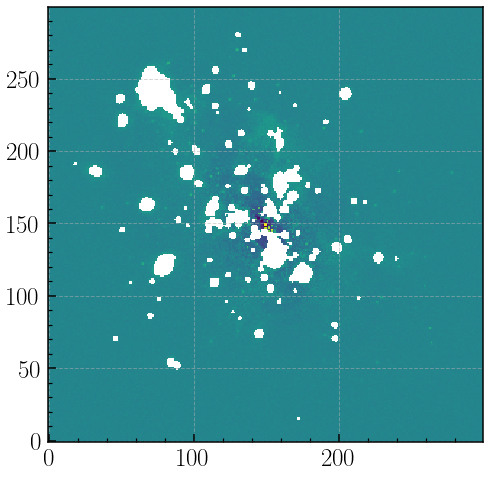

In [44]:
# Convert the segmentation map into a mask
map_mask = res_debl.data > 0

res_masked = copy.deepcopy(res_ini)
res_masked[map_mask] = np.nan

# Make a numpy masked array version of the image and mask
map_masked = ma.array(map_norm, mask=map_mask)

plt.figure(figsize=(8, 8))
plt.imshow(np.arcsinh(res_masked), origin='lower', interpolation='none')

# Masks like this one looks pretty good

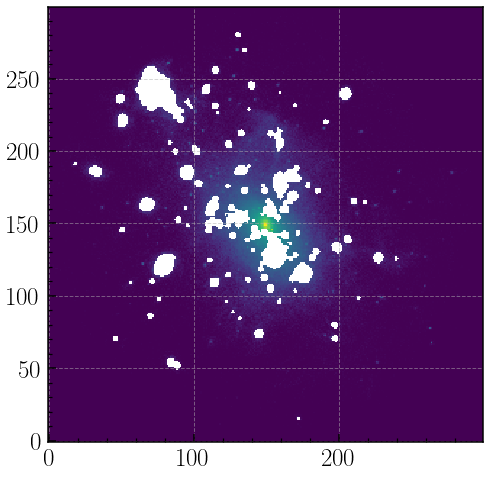

In [45]:
# Mask on the map
plt.figure(figsize=(8, 8))
plt.imshow(np.arcsinh(map_masked), origin='lower', interpolation='none')

### Estimate the shape of the galaxy

- This depends on the science goal. If you need reliable ellipticity and position angle profiles, then this step is usually necessary. But if you just want the 1-D profile using an average shape, you can directly adopt the `eps_ini` and `pa_ini` values. 
    - Using masked numpy array will significantly slow down `photutils`. This is quite unfortunate...it can be improved. 
    - Using the initial guesses will have problems if there are very strong contaminations.

In [11]:
(x0_ini, y0_ini)

(149.63082083832433, 148.80786838430944)

# Trying initial position at 10 pixel...


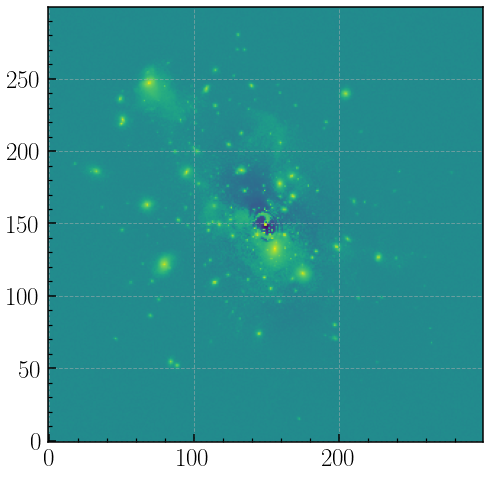

In [54]:
# Need to adjust a few parameters
sma0_geo = 10. # larger initial radius since now the central region could be affected by mask; need more pixels to be stable
sclip_geo = 3 # now that we have mask, we could use higher threshold sigma-limit
nclip_geo = 1 # don't need that many rounds of sigma-clipping
step_geo = 0.2 # larger step size will make the shape estimates more stable
fflag_geo = 0.3 # now that we have masks, we have to lower this value for the minimum fraction of non-flagged (masked) pixels.
maxsma = x_size / 2 * 1.2

# Fit the geometry of the galaxy with the mask
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    factor = np.arange(1.0, 6, 0.5)
    for ii, fac in enumerate(factor): # try a few different starting sma0
        sma0 = sma0_geo * fac
        try:
            print("# Trying initial position at {:d} pixel...".format(int(sma0)))
            geo_new = EllipseGeometry(
                x0=x0_ini, y0=y0_ini, sma=sma0, eps=eps_ini, pa=pa_ini)

            ell_geo = Ellipse(map_masked, geo_new)

            iso_geo = ell_geo.fit_image(
                sma0=sma0, minsma=0.0, maxsma=maxsma, step=step_geo, conver=0.05, minit=10, maxit=300, 
                fflag=fflag_geo, maxgerr=0.5, sclip=sclip_geo, nclip=nclip_geo, 
                integrmode=integrmode, linear=None, maxrit=None, 
                fix_center=True, fix_pa=False, fix_eps=False)
        except:
            print("# Something wrong...")
            iso_geo = []
            sma0 = sma0_geo
        if len(iso_geo) > 0:
            break
            
# Stop code 3, 4, 5 means the fitting of the isophote is not very reliable
mask_valid_geo = (iso_geo.stop_code < 3)

# Build a 2-D model based on the 1-D if there is no problematic fitting (intens is not NaN)
if (~np.isfinite(iso_geo.intens)).sum() == 0:
    mod_geo = build_ellipse_model(map_data.shape, iso_geo, high_harmonics=True)

    # Get the residual of the model 
    res_geo = map_masked - mod_geo

    # Display the residual of the model
    plt.figure(figsize=(8, 8))
    plt.imshow(np.arcsinh(map_noise - mod_geo), origin='lower')

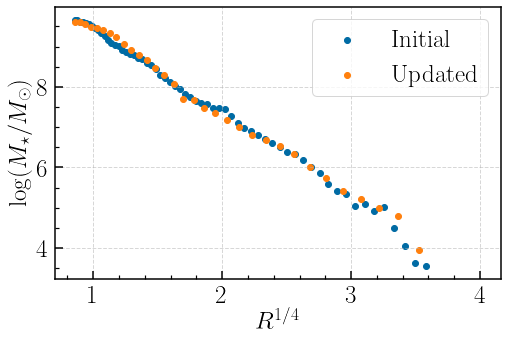

In [55]:
# Plot the mass or mass density profile depending on the unit of the map
plt.figure(figsize=(8, 5))
plt.xlim(0.7, (x_size / 2 * 2) ** 0.25)

plt.scatter(iso_ini.sma ** 0.25, np.log10(iso_ini.intens * norm_factor), label=r'$\rm Initial$')
plt.scatter(iso_geo.sma ** 0.25, np.log10(iso_geo.intens * norm_factor), label=r'$\rm Updated$')

plt.legend(fontsize=25)

_ = plt.xlabel(r'$R^{1/4}$', fontsize=25)
_ = plt.ylabel(r'$\log (M_{\star}/M_{\odot})$', fontsize=25)

# Now it is less "bumpy" thanks to the masks

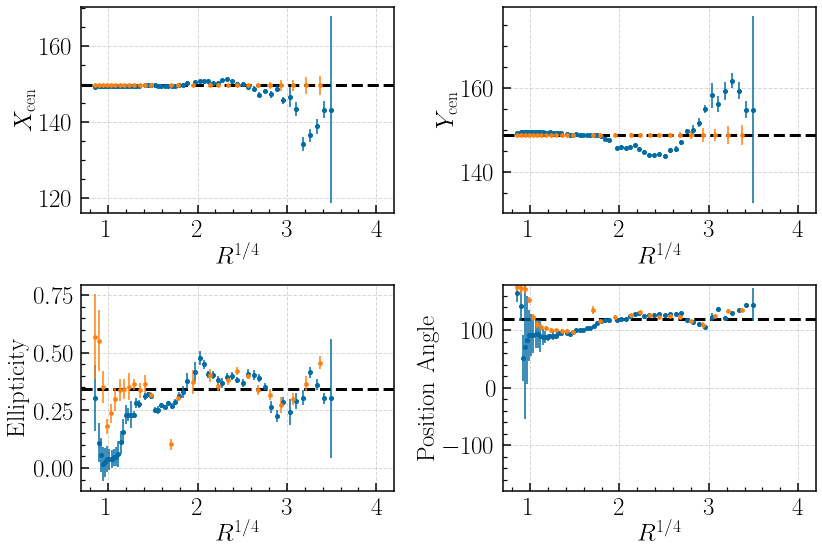

In [56]:
# We can see that the center varies a bit and the shape of the isophote changes too. 

# Updated estimates of ellipticity and position angles
x0_fin = np.mean(iso_geo.x0[mask_valid_geo & (iso_geo.sma >= 0.5) & (iso_geo.sma <= 30)])
y0_fin = np.mean(iso_geo.y0[mask_valid_geo & (iso_geo.sma >= 0.5) & (iso_geo.sma <= 30)])
eps_fin = np.mean(iso_geo.eps[mask_valid_geo & (iso_geo.sma >= 3)])
pa_fin = np.mean(iso_geo.pa[mask_valid_geo & (iso_geo.sma >= 3)])

plt.figure(figsize=(12, 8))
plt.figure(1)

plt.subplot(221)
plt.xlim(0.7, np.max(iso_ini.sma[mask_valid]) ** 0.25 * 1.2)
plt.axhline(x0_fin, linewidth=3, linestyle='--', c='k')
plt.errorbar(iso_ini.sma[mask_valid] ** 0.25, iso_ini.x0[mask_valid], 
             yerr=iso_ini.x0_err[mask_valid], fmt='o', markersize=4)
plt.errorbar(iso_geo.sma[mask_valid_geo] ** 0.25, iso_geo.x0[mask_valid_geo], 
             yerr=iso_geo.x0_err[mask_valid_geo], fmt='h', markersize=4)
_ = plt.xlabel(r'$R^{1/4}$', fontsize=25)
_ = plt.ylabel(r'$X_{\rm cen}$', fontsize=25)

plt.subplot(222)
plt.xlim(0.7, np.max(iso_ini.sma[mask_valid]) ** 0.25 * 1.2)
plt.axhline(y0_fin, linewidth=3, linestyle='--', c='k')
plt.errorbar(iso_ini.sma[mask_valid] ** 0.25, iso_ini.y0[mask_valid], 
             yerr=iso_ini.y0_err[mask_valid], fmt='o', markersize=4)
plt.errorbar(iso_geo.sma[mask_valid_geo] ** 0.25, iso_geo.y0[mask_valid_geo], 
             yerr=iso_geo.y0_err[mask_valid_geo], fmt='h', markersize=4)
_ = plt.xlabel(r'$R^{1/4}$', fontsize=25)
_ = plt.ylabel(r'$Y_{\rm cen}$', fontsize=25)

plt.subplot(223)
plt.xlim(0.7, np.max(iso_ini.sma[mask_valid]) ** 0.25 * 1.2)
plt.axhline(eps_fin, linewidth=3, linestyle='--', c='k')
plt.errorbar(iso_ini.sma[mask_valid] ** 0.25, iso_ini.eps[mask_valid], 
             yerr=iso_ini.ellip_err[mask_valid], fmt='o', markersize=4)
plt.errorbar(iso_geo.sma[mask_valid_geo] ** 0.25, iso_geo.eps[mask_valid_geo], 
             yerr=iso_geo.ellip_err[mask_valid_geo], fmt='h', markersize=4)
_ = plt.xlabel(r'$R^{1/4}$', fontsize=25)
_ = plt.ylabel(r'$\rm Ellipticity$', fontsize=25)

plt.subplot(224)
plt.xlim(0.7, np.max(iso_ini.sma[mask_valid]) ** 0.25 * 1.2)
plt.ylim(-179, 179)
plt.axhline(pa_fin * 180.0 / np.pi, linewidth=3, linestyle='--', c='k')
plt.errorbar(iso_ini.sma[mask_valid] ** 0.25, iso_ini.pa[mask_valid] * 180.0 / np.pi, 
             yerr=(iso_ini.pa_err[mask_valid] * 180.0 / np.pi), fmt='o', markersize=4)
plt.errorbar(iso_geo.sma[mask_valid_geo] ** 0.25, iso_geo.pa[mask_valid_geo] * 180.0 / np.pi, 
             yerr=(iso_geo.pa_err[mask_valid_geo] * 180.0 / np.pi), fmt='h', markersize=4)
_ = plt.xlabel(r'$R^{1/4}$', fontsize=25, c='k')
_ = plt.ylabel(r'$\rm Position\ Angle$', fontsize=25)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

### Extract the 1-D profile fixing the shape of the galaxy

- This is the final surface density profile

In [78]:
# If you decide to run the above second step, you can use the updated geometry of the galaxy
(x0_fin, y0_fin, eps_fin, pa_fin)

(149.63082083832433,
 148.80786838430947,
 0.34180894662631617,
 2.091460381790354)

/tmp/ipykernel_59875/1732101800.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(iso_sbp.sma ** 0.25, np.log10(iso_sbp.intens * norm_factor), label=r'$\rm Final$')


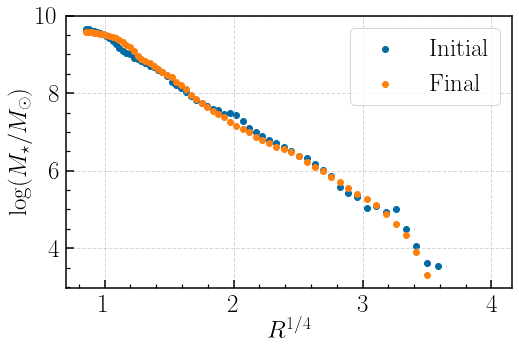

In [79]:
iso_sbp_list = []

sclip_sbp = 2.5
nclip_sbp = 2

for sma in iso_ini.sma:
    iso_sbp_list.append(
        integrate_isophot_one(
            map_masked, sma, pa_fin, eps_fin, x0_fin, y0_fin, 
            integrmode, sclip_sbp, nclip_sbp))
    
iso_sbp = IsophoteList(iso_sbp_list)

iso_tab = iso_sbp.to_table()

# Plot the mass or mass density profile depending on the unit of the map
plt.figure(figsize=(8, 5))
plt.xlim(0.7, (x_size / 2 * 2) ** 0.25)

plt.scatter(iso_ini.sma ** 0.25, np.log10(iso_ini.intens * norm_factor), label=r'$\rm Initial$')
plt.scatter(iso_sbp.sma ** 0.25, np.log10(iso_sbp.intens * norm_factor), label=r'$\rm Final$')

plt.legend(fontsize=25)

_ = plt.xlabel(r'$R^{1/4}$', fontsize=25)
_ = plt.ylabel(r'$\log (M_{\star}/M_{\odot})$', fontsize=25)

### Curve of growth and the total mass within an aperture

- Now that we have the 1-D profile using the fixed shape, we can integrate it to estimate the total mass within an aperture. 
- We usually call that the "curve of growth". 
- **Note** that I didn't check the unit, so the mass value maybe off by a factor if the unit of the map is mass density.

/tmp/ipykernel_59875/146647737.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(iso_sbp.sma ** 0.25, np.log10(cog))


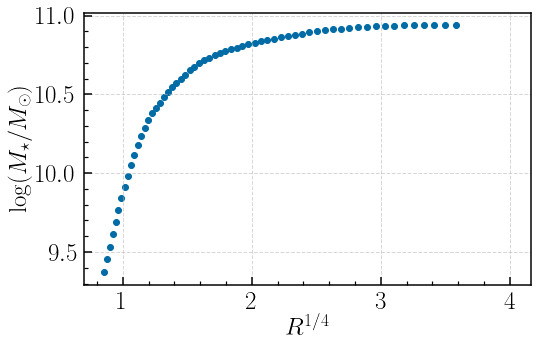

In [92]:
ell_area = np.pi * ((iso_tab['sma'] ** 2.0) * (1.0 - iso_tab['ellipticity']))
iso_intens = iso_tab['intens'] * norm_factor
iso_flux = np.append(ell_area[0], [ell_area[1:] - ell_area[:-1]]) * iso_intens
cog = np.asarray(list(map(lambda x: np.nansum(iso_flux[0:x + 1]), range(iso_flux.shape[0]))))

plt.figure(figsize=(8, 5))
plt.xlim(0.7, (x_size / 2 * 2) ** 0.25)

plt.scatter(iso_sbp.sma ** 0.25, np.log10(cog))

_ = plt.xlabel(r'$R^{1/4}$', fontsize=25)
_ = plt.ylabel(r'$\log (M_{\star}/M_{\odot})$', fontsize=25)

### Alternative approach to get a mask 

- In the above example, we run an initial isophote run to get the basic model of the galaxy, then use the residual to obtain an object mask. 
- In some cases, this approach might be difficult. We could use a simple way to get the mask.

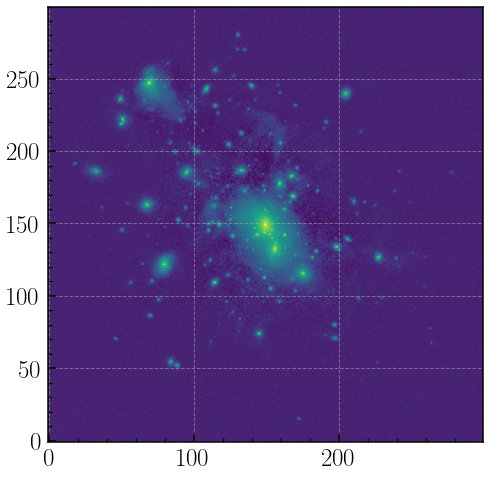

In [117]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = SExtractorBackground()
bkg = Background2D(map_noise, (15, 15), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

map_sub = map_noise - bkg.background

plt.figure(figsize=(8, 8))
plt.imshow(np.arcsinh(map_sub), origin='lower')

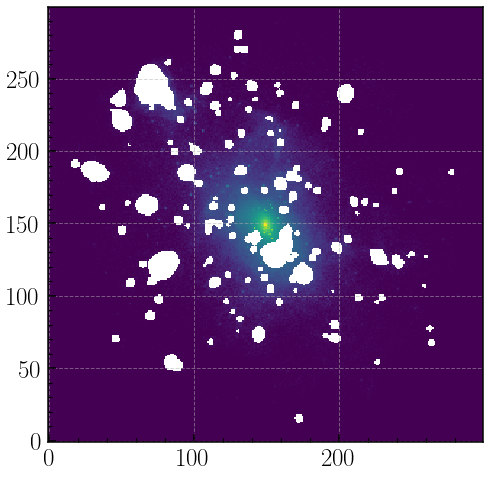

In [119]:
sigma = 3.0 * gaussian_fwhm_to_sigma 
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
kernel.normalize()

threshold = bkg.background + (2.0 * bkg.background_rms)

segm = detect_sources(map_sub, threshold, npixels=3, kernel=kernel)

segm_deb = deblend_sources(
    map_sub, segm, npixels=5, kernel=kernel, nlevels=64, contrast=0.001)

# We need to remove the segment at the center of the image 
# Define a small area around the center, and remove the segments there
cen_rad = 3
cen_low = int(x_size / 2 - 3)
cen_upp = int(x_size / 2 + 3)

idx_cen = np.unique(segm_deb.data[cen_low:cen_upp, cen_low:cen_upp].flatten())
idx_cen = idx_cen[idx_cen > 0]

segm_deb.remove_labels(idx_cen)

# Make a mask
seg_mask = segm_deb.data > 0

# Make a numpy masked array version of the image and mask
map_masked_2 = ma.array(map_norm, mask=seg_mask)

plt.figure(figsize=(8, 8))
#plt.imshow(segm_deb, origin='lower', cmap=segm.make_cmap(seed=123), interpolation='none')
plt.imshow(np.arcsinh(map_masked_2), origin='lower', interpolation='none')

In [71]:
def integrate_isophot_one(img, sma, theta, eps, x0, y0, 
                          integrmode, sclip, nclip):
    """Integrate the ellipse profile at a single semi-major axis.
    theta in radians
    """
    g = EllipseGeometry(x0=x0, y0=y0, eps=eps, sma=sma, pa=theta)

    # Use the same integration mode and clipping parameters.
    # The central pixel is a special case:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        if g.sma == 0.0:
            gcen = copy.deepcopy(g)
            gcen.sma = 0.0
            gcen.eps = 0.0
            gcen.pa = 0.0
            censamp = CentralEllipseSample(
                img, 0.0, geometry=gcen, integrmode=integrmode, sclip=sclip, nclip=nclip)
            iso = CentralEllipseFitter(censamp).fit()
        else:
            sample = EllipseSample(
                img, sma=g.sma, geometry=g, integrmode=integrmode, sclip=sclip, nclip=nclip)
            sample.update(fixed_parameters=True)

            # Create an Isophote instance with the sample.
            iso = Isophote(sample, 0, True, 0)
        
    return iso

In [15]:
def random_cmap(ncolors=256, background_color='white'):
    """Random color maps.
    Generate a matplotlib colormap consisting of random (muted) colors.
    A random colormap is very useful for plotting segmentation images.
    Parameters
    ----------
    ncolors : int, optional
        The number of colors in the colormap.  The default is 256.
    random_state : int or `~numpy.random.RandomState`, optional
        The pseudo-random number generator state used for random
        sampling.  Separate function calls with the same
        ``random_state`` will generate the same colormap.
    Returns
    -------
    cmap : `matplotlib.colors.Colormap`
        The matplotlib colormap with random colors.
    Notes
    -----
    Based on: colormaps.py in photutils
    """
    prng = np.random.mtrand._rand

    h = prng.uniform(low=0.0, high=1.0, size=ncolors)
    s = prng.uniform(low=0.2, high=0.7, size=ncolors)
    v = prng.uniform(low=0.5, high=1.0, size=ncolors)

    hsv = np.dstack((h, s, v))
    rgb = np.squeeze(colors.hsv_to_rgb(hsv))

    if background_color is not None:
        if background_color not in colors.cnames:
            raise ValueError('"{0}" is not a valid background color '
                             'name'.format(background_color))
        rgb[0] = colors.hex2color(colors.cnames[background_color])

    return colors.ListedColormap(rgb)